Data loaded successfully. Shape: (50000, 23)


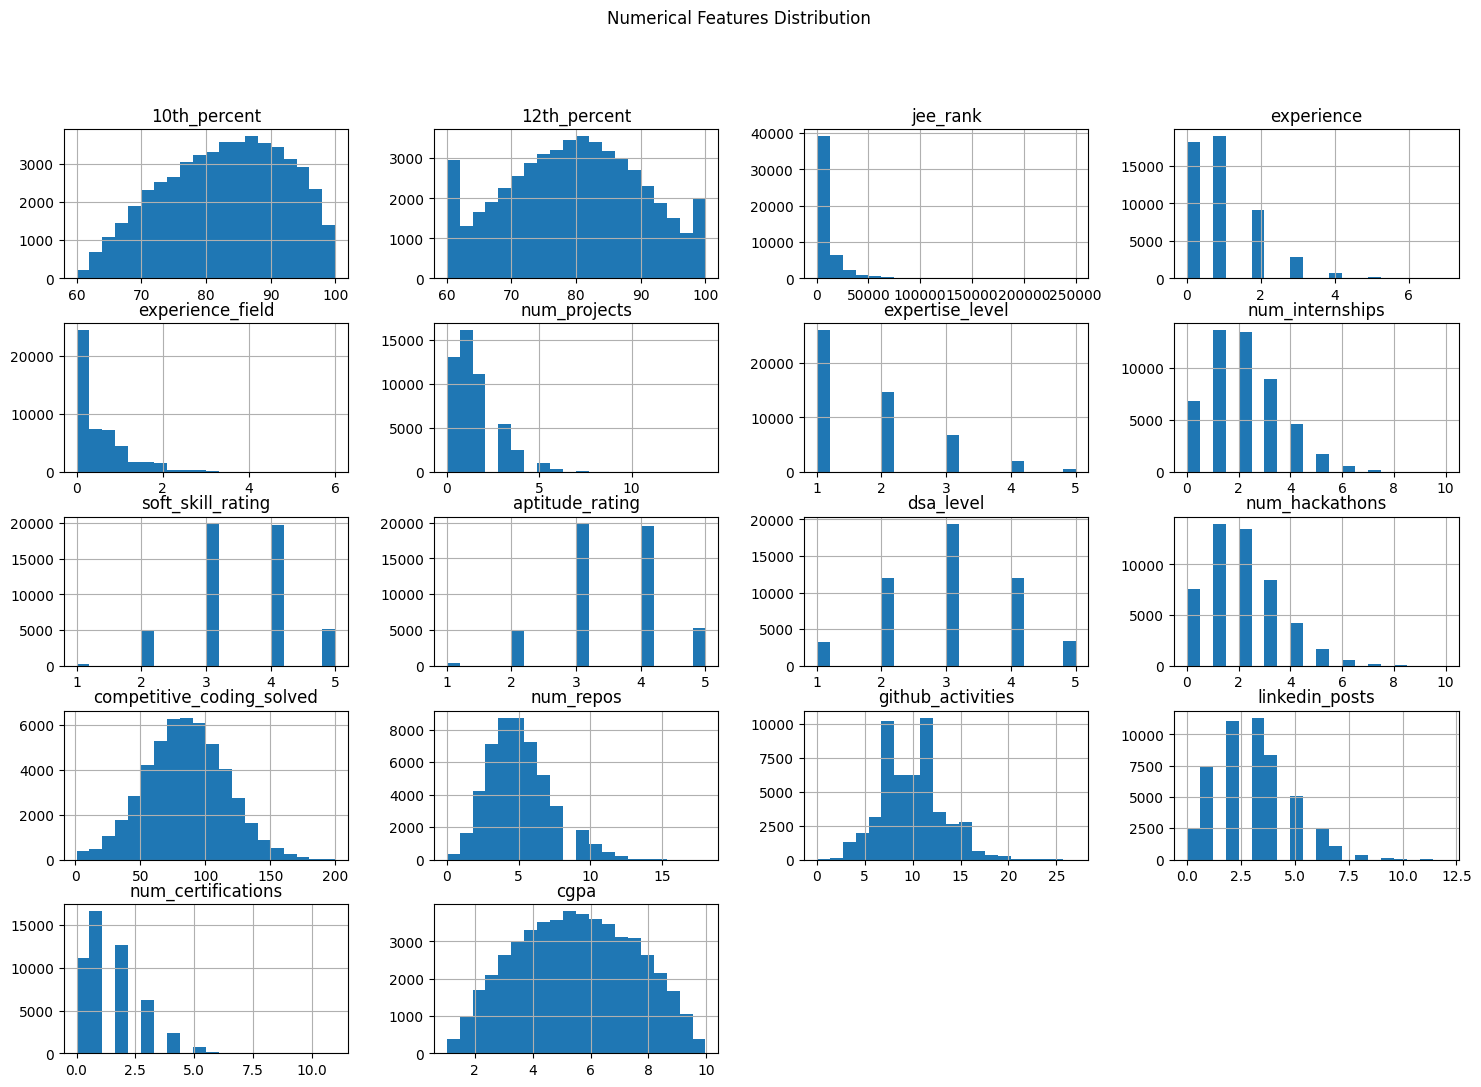

C:\Users\Akash\AppData\Local\Temp\ipykernel_3860\3501845100.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")


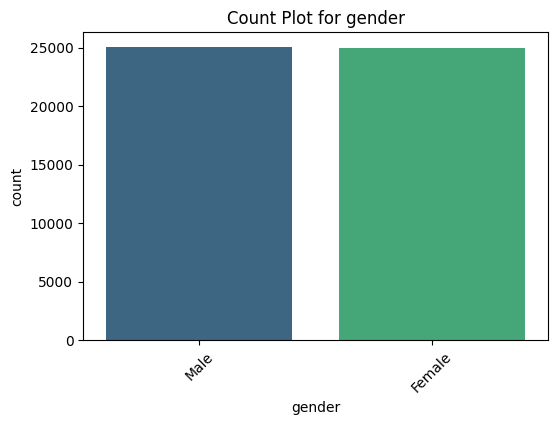

C:\Users\Akash\AppData\Local\Temp\ipykernel_3860\3501845100.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")


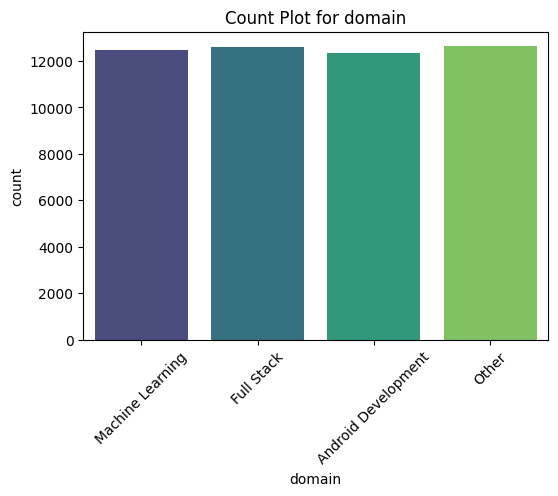

C:\Users\Akash\AppData\Local\Temp\ipykernel_3860\3501845100.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")


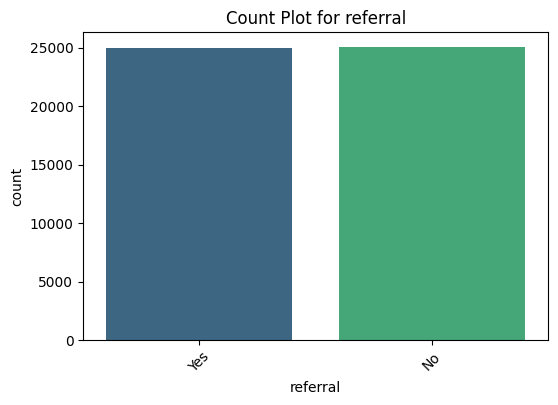

C:\Users\Akash\AppData\Local\Temp\ipykernel_3860\3501845100.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")


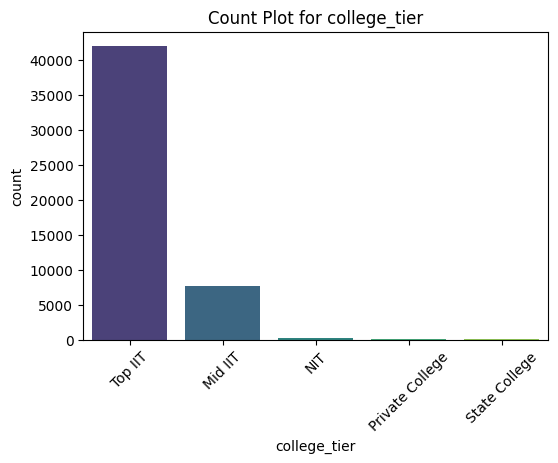

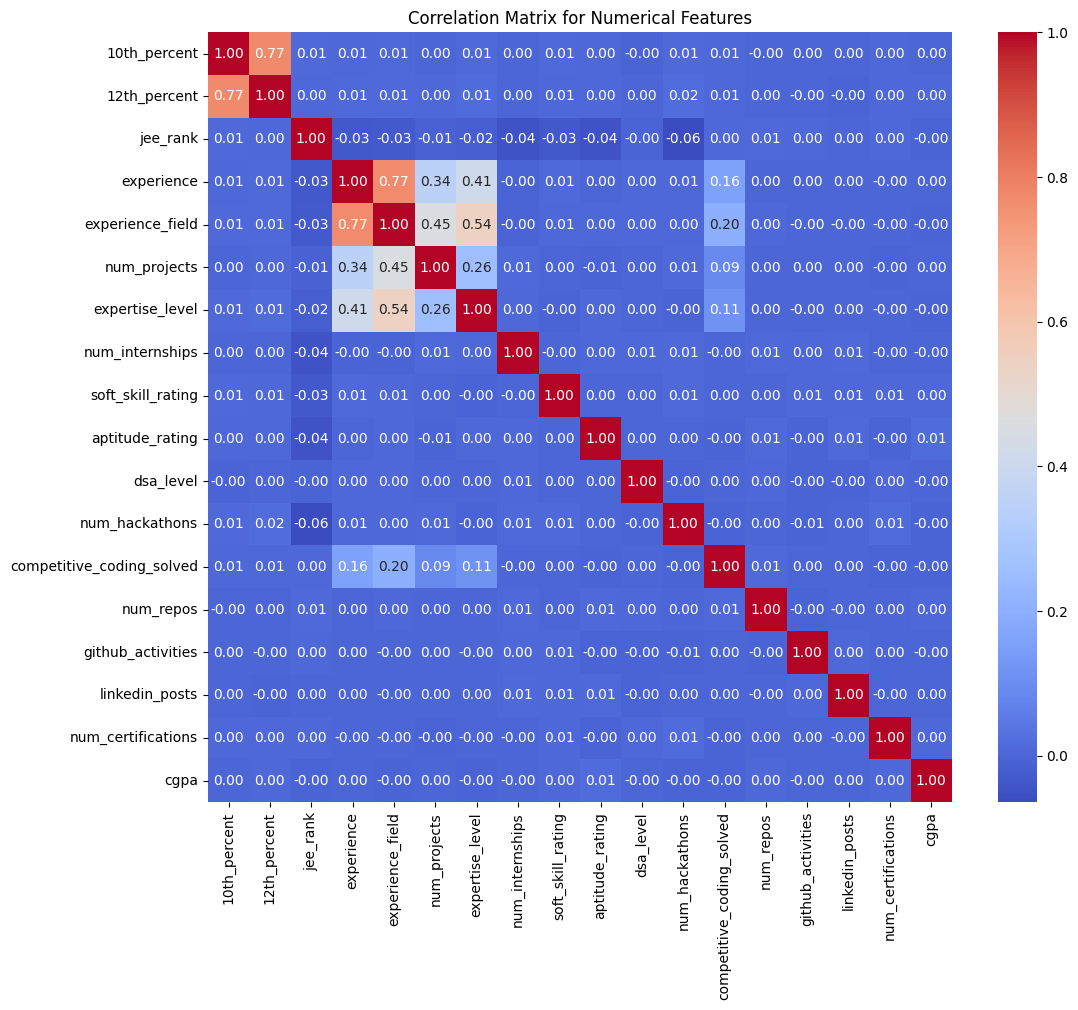

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, mean_absolute_error, r2_score,
                             confusion_matrix, classification_report,
                             mean_squared_error)
from xgboost import XGBClassifier, XGBRegressor
import joblib

# Load dataset (ensure 'engineering_data23.csv' is in your Colab files)
df = pd.read_csv('engineering_data_IMPRV.csv')

# Define features and target columns
numerical_features = [
    '10th_percent', '12th_percent', 'jee_rank', 'experience', 'experience_field',
    'num_projects', 'expertise_level', 'num_internships', 'soft_skill_rating',
    'aptitude_rating', 'dsa_level', 'num_hackathons', 'competitive_coding_solved',
    'num_repos', 'github_activities', 'linkedin_posts', 'num_certifications', 'cgpa'
]
categorical_features = ['gender', 'domain', 'referral']

target_col_college = 'college_tier'
target_col_salary = 'salary'

# Ensure required columns are present
required_columns = numerical_features + categorical_features + [target_col_college, target_col_salary]
df = df[required_columns]
print("Data loaded successfully. Shape:", df.shape)

# Quick EDA: Plot distribution for numerical features
df[numerical_features].hist(figsize=(18, 12), bins=20)
plt.suptitle("Numerical Features Distribution")
plt.show()

# Count plots for categorical features
for col in categorical_features + [target_col_college]:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, palette="viridis")
    plt.title(f"Count Plot for {col}")
    plt.xticks(rotation=45)
    plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(12, 10))
corr = df[numerical_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix for Numerical Features")
plt.show()


Data preprocessed and split into training and test sets.


C:\Users\Akash\AppData\Local\Temp\ipykernel_3860\2128316507.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_college_train.astype(int), palette="magma")
C:\Users\Akash\AppData\Local\Temp\ipykernel_3860\2128316507.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_college_test.astype(int), palette="magma")


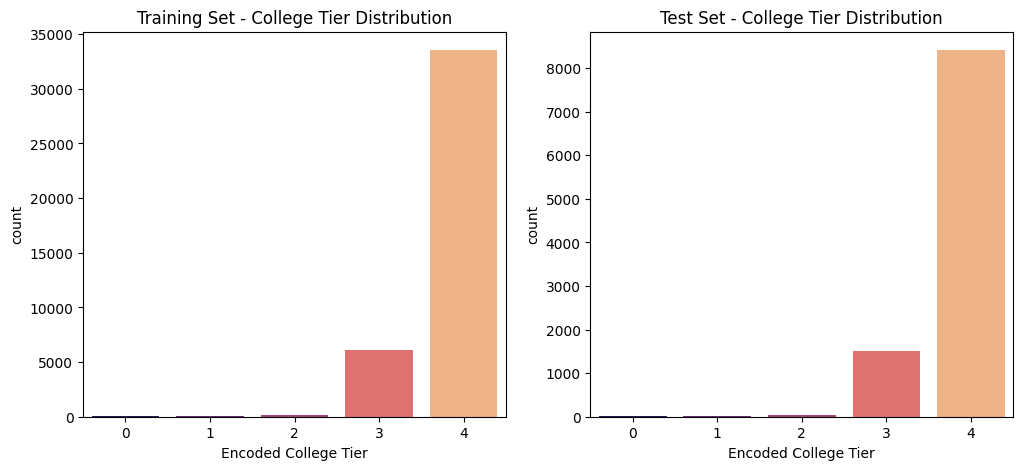

In [2]:
# Define college tier hierarchy and encode the target
college_hierarchy = ['Private College', 'State College', 'NIT', 'Mid IIT', 'Top IIT']
college_encoder = OrdinalEncoder(categories=[college_hierarchy])
df['college_tier_encoded'] = college_encoder.fit_transform(df[[target_col_college]])

# Split features and targets
X = df[numerical_features + categorical_features]
y_college = df['college_tier_encoded']
y_salary = df[target_col_salary]

# Train-test split (80% training, 20% testing)
X_train, X_test, y_college_train, y_college_test, y_salary_train, y_salary_test = train_test_split(
    X, y_college, y_salary, test_size=0.2, random_state=42
)
print("Data preprocessed and split into training and test sets.")

# Plot target distribution on training and test sets (for College Tier)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_college_train.astype(int), palette="magma")
plt.title("Training Set - College Tier Distribution")
plt.xlabel("Encoded College Tier")
plt.subplot(1, 2, 2)
sns.countplot(x=y_college_test.astype(int), palette="magma")
plt.title("Test Set - College Tier Distribution")
plt.xlabel("Encoded College Tier")
plt.show()


In [3]:
# Preprocessor: Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline for College Admission Prediction (Classification)
college_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        use_label_encoder=False
    ))
])

# Pipeline for Salary Prediction (Regression)
salary_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define hyperparameter grids
college_params = {
    'model__n_estimators': [500, 1000],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [5, 7]
}

salary_params = {
    'model__n_estimators': [800, 1200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

print("Pipelines and hyperparameter grids set up.")

# Train College Predictor using GridSearchCV
print("Training College Prediction Model...")
college_grid = GridSearchCV(college_pipeline, college_params, cv=5, scoring='accuracy', n_jobs=-1)
college_grid.fit(X_train, y_college_train)
best_college_model = college_grid.best_estimator_
print("Best parameters for College Prediction:", college_grid.best_params_)

# Train Salary Predictor using GridSearchCV
print("\nTraining Salary Prediction Model...")
salary_grid = GridSearchCV(salary_pipeline, salary_params, cv=5, scoring='r2', n_jobs=-1)
salary_grid.fit(X_train, y_salary_train)
best_salary_model = salary_grid.best_estimator_
print("Best parameters for Salary Prediction:", salary_grid.best_params_)


Pipelines and hyperparameter grids set up.
Training College Prediction Model...


c:\Users\Akash\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:57:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for College Prediction: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 500}

Training Salary Prediction Model...
Best parameters for Salary Prediction: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 800}


In [4]:
def evaluate_models():
    # ---------- College Prediction Evaluation ----------
    college_preds = best_college_model.predict(X_test)
    acc = accuracy_score(y_college_test, college_preds)
    print("\nCollege Prediction Metrics:")
    print("Best Parameters:", college_grid.best_params_)
    print(f"Accuracy: {acc:.2%}")
    print("\nClassification Report:")
    print(classification_report(y_college_test, college_preds, target_names=college_hierarchy))
    
    # Confusion Matrix Plot
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_college_test, college_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=college_hierarchy, yticklabels=college_hierarchy)
    plt.title('College Tier Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.show()
    
    # ---------- Salary Prediction Evaluation ----------
    salary_preds = best_salary_model.predict(X_test)
    mae = mean_absolute_error(y_salary_test, salary_preds)
    rmse = np.sqrt(mean_squared_error(y_salary_test, salary_preds))
    r2 = r2_score(y_salary_test, salary_preds)
    
    print("\nSalary Prediction Metrics:")
    print("Best Parameters:", salary_grid.best_params_)
    print(f"MAE: ₹{mae:,.0f}")
    print(f"RMSE: ₹{rmse:,.0f}")
    print(f"R² Score: {r2:.2%}")
    
    # Scatter Plot: Actual vs Predicted Salary
    plt.figure(figsize=(10, 6))
    plt.scatter(y_salary_test, salary_preds, alpha=0.3)
    plt.plot([y_salary_test.min(), y_salary_test.max()],
             [y_salary_test.min(), y_salary_test.max()], 'r--')
    plt.xlabel('Actual Salary')
    plt.ylabel('Predicted Salary')
    plt.title('Actual vs Predicted Salary')
    plt.show()
    
    # ---------- Feature Importance Visualization ----------
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # College Prediction Feature Importance
    college_importances = best_college_model.named_steps['model'].feature_importances_
    features = best_college_model.named_steps['preprocessor'].get_feature_names_out()
    pd.Series(college_importances, index=features).sort_values().plot.barh(ax=ax[0])
    ax[0].set_title('College Prediction Feature Importance')
    
    # Salary Prediction Feature Importance
    salary_importances = best_salary_model.named_steps['model'].feature_importances_
    pd.Series(salary_importances, index=features).sort_values().plot.barh(ax=ax[1])
    ax[1].set_title('Salary Prediction Feature Importance')
    
    plt.tight_layout()
    plt.show()

# Uncomment the following line to run the evaluation:
# evaluate_models()


In [5]:
def predict_admission_interactive():
    # Define widgets for numerical inputs
    tenth_widget = widgets.FloatText(value=80.0, description='10th %:')
    twelfth_widget = widgets.FloatText(value=80.0, description='12th %:')
    jee_widget = widgets.IntText(value=1000, description='JEE Rank:')
    workexp_widget = widgets.IntText(value=2, description='Work Exp (yrs):')
    exp_field_widget = widgets.Dropdown(options=list(range(0, 21)), value=2, description='Field Exp:')
    projects_widget = widgets.Dropdown(options=list(range(0, 21)), value=1, description='Projects:')
    expertise_widget = widgets.Dropdown(options=[1, 2, 3, 4, 5], value=3, description='Expertise:')
    internships_widget = widgets.Dropdown(options=list(range(0, 11)), value=0, description='Internships:')
    softskill_widget = widgets.Dropdown(options=[1, 2, 3, 4, 5], value=3, description='Soft Skills:')
    aptitude_widget = widgets.Dropdown(options=[1, 2, 3, 4, 5], value=3, description='Aptitude:')
    dsa_widget = widgets.Dropdown(options=[1, 2, 3, 4, 5], value=3, description='DSA Level:')
    hackathons_widget = widgets.Dropdown(options=list(range(0, 11)), value=0, description='Hackathons:')
    coding_widget = widgets.Dropdown(options=list(range(0, 201, 10)), value=50, description='Coding Qs:')
    repos_widget = widgets.Dropdown(options=list(range(0, 51)), value=5, description='Repos:')
    github_widget = widgets.Dropdown(options=list(range(0, 51)), value=10, description='GitHub Acts:')
    linkedin_widget = widgets.Dropdown(options=list(range(0, 51)), value=3, description='LinkedIn Posts:')
    certs_widget = widgets.Dropdown(options=list(range(0, 21)), value=0, description='Certifications:')
    cgpa_widget = widgets.Dropdown(options=[round(x,1) for x in np.arange(1,10.1,0.5)], value=7.0, description='CGPA:')

    # Widgets for categorical inputs
    gender_widget = widgets.Dropdown(options=['Male', 'Female', 'Other'], value='Male', description='Gender:')
    domain_widget = widgets.Dropdown(options=['Full Stack', 'Machine Learning', 'Android Development', 'Other'],
                                     value='Full Stack', description='Domain:')
    referral_widget = widgets.Dropdown(options=['Yes', 'No'], value='No', description='Referral:')

    submit_button = widgets.Button(description="Predict")
    output = widgets.Output()

    def on_submit(b):
        with output:
            clear_output()
            # Gather user inputs into a dictionary
            user_input = {
                '10th_percent': tenth_widget.value,
                '12th_percent': twelfth_widget.value,
                'jee_rank': jee_widget.value,
                'experience': workexp_widget.value,
                'experience_field': exp_field_widget.value,
                'num_projects': projects_widget.value,
                'expertise_level': expertise_widget.value,
                'num_internships': internships_widget.value,
                'soft_skill_rating': softskill_widget.value,
                'aptitude_rating': aptitude_widget.value,
                'dsa_level': dsa_widget.value,
                'num_hackathons': hackathons_widget.value,
                'competitive_coding_solved': coding_widget.value,
                'num_repos': repos_widget.value,
                'github_activities': github_widget.value,
                'linkedin_posts': linkedin_widget.value,
                'num_certifications': certs_widget.value,
                'cgpa': cgpa_widget.value,
                'gender': gender_widget.value,
                'domain': domain_widget.value,
                'referral': referral_widget.value
            }
            input_df = pd.DataFrame([user_input])
            
            # College Prediction
            college_code = best_college_model.predict(input_df)[0]
            predicted_college = college_hierarchy[int(college_code)]
            
            # Salary Prediction
            predicted_salary = best_salary_model.predict(input_df)[0]
            
            print("\nPrediction Results:")
            print(f"Predicted College Tier: {predicted_college}")
            print(f"Estimated Annual Salary: ₹{predicted_salary:,.2f}")

    submit_button.on_click(on_submit)

    # Organize widgets in a clean layout
    input_widgets = widgets.VBox([
        widgets.HBox([tenth_widget, twelfth_widget, jee_widget]),
        widgets.HBox([workexp_widget, exp_field_widget]),
        widgets.HBox([projects_widget, expertise_widget, internships_widget]),
        widgets.HBox([softskill_widget, aptitude_widget, dsa_widget]),
        widgets.HBox([hackathons_widget, coding_widget]),
        widgets.HBox([repos_widget, github_widget, linkedin_widget]),
        widgets.HBox([certs_widget, cgpa_widget]),
        widgets.HBox([gender_widget, domain_widget, referral_widget]),
        submit_button,
        output
    ])
    display(input_widgets)

# Run the interactive prediction interface
predict_admission_interactive()


In [6]:
# --- Performance Metrics Check Block ---
# For College Prediction (Classification Accuracy)
college_preds = best_college_model.predict(X_test)
college_accuracy = accuracy_score(y_college_test, college_preds)
print("College Prediction Accuracy: {:.2%}".format(college_accuracy))

# For Salary Prediction (R² Score)
salary_preds = best_salary_model.predict(X_test)
salary_r2 = r2_score(y_salary_test, salary_preds)
print("Salary Prediction R² Score: {:.2%}".format(salary_r2))


College Prediction Accuracy: 84.42%
Salary Prediction R² Score: 12.14%


In [7]:
joblib.dump(best_college_model, 'college_predictor.pkl')
joblib.dump(best_salary_model, 'salary_predictor.pkl')
print("\nModels saved as 'college_predictor.pkl' and 'salary_predictor.pkl'.")



Models saved as 'college_predictor.pkl' and 'salary_predictor.pkl'.
